In [72]:
import pandas as pd 

In [73]:
df_combine = pd.read_csv('./new_data/combine_accident_normalized_text.csv')

In [74]:
df_combine = df_combine.drop(df_combine.columns[:2], axis=1)

In [75]:
df_combine.head(5)

,text_normalized,target
0,deeds reason earthquake may allah forgive,1
1,forest fire near ronge sask canada,1
2,residents asked shelter place being notifi...,1
3,people receive wildfires evacuation orders ca...,1
4,just photo ruby alaska smoke wildfires p...,1


In [76]:

from wordcloud import WordCloud

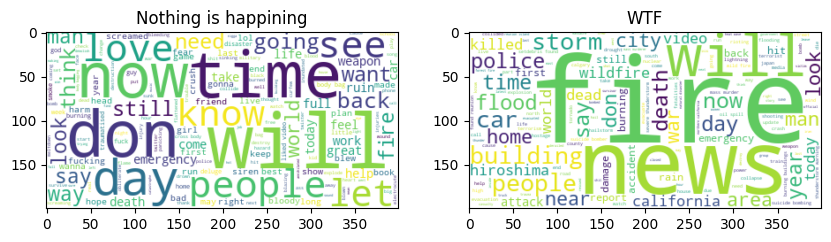

In [77]:
negative_cases = "".join(df_combine[df_combine['target'] == 0]['text_normalized'].values)
positive_cases = "".join(df_combine[df_combine['target'] == 1]['text_normalized'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Nothing is happining')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('WTF')

plt.show()

TF-IDF vectorization

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [79]:

# Define TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the text data
X = vectorizer.fit_transform(df_combine['text_normalized'])

# Define target variable
y = df_combine['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


Model Building

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [82]:
# Fit different models
xgb_model = XGBClassifier().fit(X_train, y_train)
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
lr_model = LogisticRegression().fit(X_train, y_train)
nb_model = MultinomialNB().fit(X_train, y_train)
svm_model = LinearSVC().fit(X_train, y_train)
rf_model = RandomForestClassifier().fit(X_train, y_train)
gb_model = GradientBoostingClassifier().fit(X_train, y_train)

Model Evaluation

<AxesSubplot: >

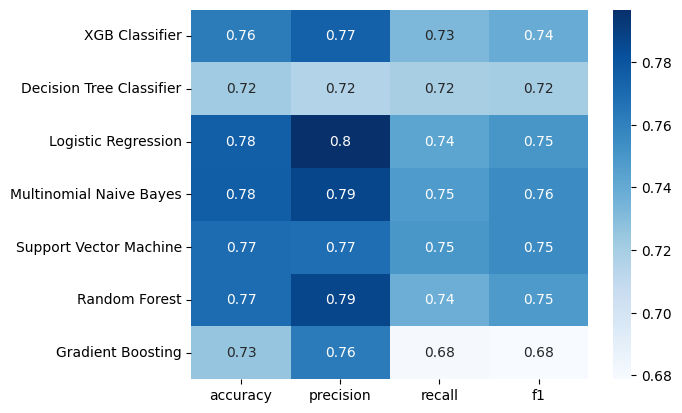

In [83]:
import seaborn as sns 
# Define a function that takes a model, X, and y and returns the accuracy, precision, recall, and F1 score using 10-fold cross-validation.
def evaluate_model(model, X, y):
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=5, scoring='precision_macro')
    recall = cross_val_score(model, X, y, cv=5, scoring='recall_macro')
    f1 = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    return {'accuracy': accuracy.mean(), 'precision': precision.mean(), 'recall': recall.mean(), 'f1': f1.mean()}

# A dictionary that maps each model to its name
models = {'XGB Classifier': xgb_model, 'Decision Tree Classifier': dt_model, 'Logistic Regression': lr_model, 'Multinomial Naive Bayes': nb_model, 'Support Vector Machine': svm_model, 'Random Forest': rf_model, 'Gradient Boosting': gb_model}

# Create an empty dictionary to store the evaluation results
results = {}

# Loop through models and evaluate
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train)

# Create a DataFrame from the results dictionary.
results_df = pd.DataFrame.from_dict(results, orient='index')
sns.heatmap(results_df, cmap='Blues', annot=True)

Deep Learning

Word embeddings with GloVe

In [84]:
import numpy as np
import tensorflow as tf
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional, Dropout, GlobalMaxPool1D, BatchNormalization

In [145]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combine['text_normalized'], df_combine['target'], test_size=0.2, random_state=11)

# Convert the text data into sequences of integer values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure they all have the same length
maxlen = 50
X_train_padded = pad_sequences(X_train_sequences, padding='post', truncating='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, padding='post', truncating='post', maxlen=maxlen)

# Путь к скаченному файлу с векторами GloVe
glove_file = '/Users/semenermolinskij/Projects/data/glove.twitter.27B/glove.twitter.27B.200d.txt'

# Загрузка предобученных векторов GloVe
word_vectors = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# Create the embedding layer
embedding_dim = 200
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)

LSTM Model

In [109]:
from keras import regularizers

In [146]:
# Define the LSTM model
model = Sequential()
model.add(embedding_layer)
    
model.add(Bidirectional(LSTM(
        100, 
        return_sequences=True, 
        recurrent_dropout=0.2,
        kernel_regularizer=regularizers.l2(0.01),  # Добавление регуляризации к весам
        )))  
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = "tanh"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=7, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/7
170/170 [==============================] - 17s 86ms/step - loss: 2.9581 - accuracy: 0.7417 - val_loss: 1.5506 - val_accuracy: 0.8044
Epoch 2/7
170/170 [==============================] - 17s 101ms/step - loss: 1.2406 - accuracy: 0.7761 - val_loss: 0.9998 - val_accuracy: 0.7875
Epoch 3/7
170/170 [==============================] - 18s 104ms/step - loss: 0.8743 - accuracy: 0.7951 - val_loss: 0.7698 - val_accuracy: 0.7949
Epoch 4/7
170/170 [==============================] - 18s 107ms/step - loss: 0.7036 - accuracy: 0.7982 - val_loss: 0.6787 - val_accuracy: 0.7926
Epoch 5/7
170/170 [==============================] - 18s 103ms/step - loss: 0.6210 - accuracy: 0.8043 - val_loss: 0.6119 - val_accuracy: 0.8051
Epoch 6/7
170/170 [==============================] - 17s 101ms/step - loss: 0.5754 - accuracy: 0.8074 - val_loss: 0.5978 - val_accuracy: 0.7831
Epoch 7/7
170/170 [==============================] - 19s 109ms/step - loss: 0.5481 - accuracy: 0.8135 - val_loss: 0.5706 - val_accuracy: 

Model Evaluation

In [147]:
y_pred = model.predict(X_test_padded)
y_pred_rounded = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_rounded)
precision = precision_score(y_test, y_pred_rounded)
recall = recall_score(y_test, y_pred_rounded)
f1 = f1_score(y_test, y_pred_rounded)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1) 

43/43 [==============================] - 1s 20ms/step
Accuracy: 0.7977941176470589
Precision: 0.8109339407744874
Recall: 0.6496350364963503
F1 score: 0.7213779128672746


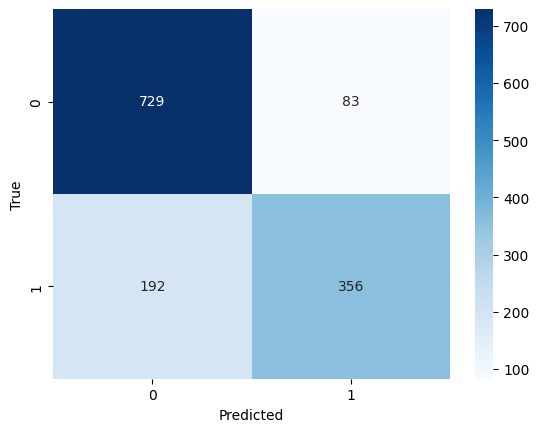

In [148]:
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
 
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rounded)
 
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()